Natural Language Processing (NLP) From Scratch: Translation with a Sequence to Sequence Network
===============================================================================================

**Original Author**: [Sean Robertson](https://github.com/spro)

**Link for original tutorial**: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

**Rewritten by Chen to clarify the most important concepts**

Overview: In this project we will be teaching a neural network to translate from English to Korean. 
This is made possible by the simple but powerful idea of the [sequence
to sequence network](https://arxiv.org/abs/1409.3215), in which two
recurrent neural networks (encoder and decoder) work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.

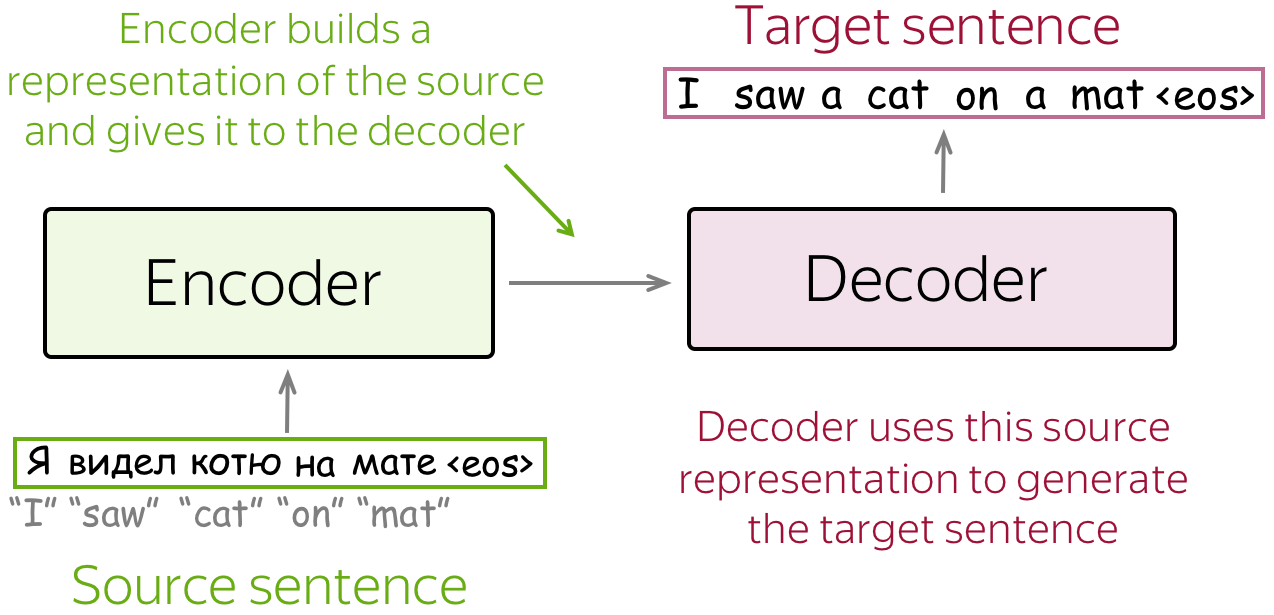

In [1]:
from IPython.display import Image
Image(filename='image/encoder_decoder_high_level_concept.png', width=500)

## Requirements

In [2]:
import numpy as np
from io import open
import re
import string

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Step 1: Read data and split lines into pairs of English and Korean sentences

In [3]:
# read data and show the first 5 lines
lang1 = 'Eng'
lang2 = 'Kor'
lines = open('data/%s-%s.txt' % (lang1, lang2)).read().strip().split('\n')
for l in lines[0:5]:
    print(l)

Go.	가.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8363271 (Eunhee)
Hi.	안녕.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #8355888 (Eunhee)
Run!	뛰어!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #8355891 (Eunhee)
Run.	뛰어.	CC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #8363273 (Eunhee)
Who?	누구?	CC-BY 2.0 (France) Attribution: tatoeba.org #2083030 (CK) & #6820074 (yesjustryan)


In [4]:
pairs = []
for l in lines:
    input_lang_sentence = l.split('\t')[0]
    target_lang_sentence = l.split('\t')[1]

    # normalization: transform sentences into lowercase, remove leading and trailing spaces, and trim punctuations (.!?)
    input_lang_sentence = input_lang_sentence.lower().strip().translate(str.maketrans('', '', '.!?'))
    target_lang_sentence = target_lang_sentence.lower().strip().translate(str.maketrans('', '', '.!?'))
    
    pairs.append([input_lang_sentence, target_lang_sentence])

print("Number of English and Korean sentence pairs = %d"%(len(pairs)))

Number of English and Korean sentence pairs = 5890


In [5]:
pairs[1000:1005]

[["i'm just sleepy", '나 졸려'],
 ["i'm not sulking", '나 삐친 거 아니야'],
 ["i'm on the list", '나는 명단에 있다'],
 ['is tom with you', '톰이랑 같이 있어'],
 ['is anybody home', '누구 집에 있어요']]

## Step 2: Determine the maximum sentence length
Sentences have varying length (number of words). The majority of sentences are short, while there are a few very long sentences. In the following, we will count the frequency of sentence length and find a cutoff below which most of the data are contained. This cutoff will be used as the maximum sequnece length in training data preparation.

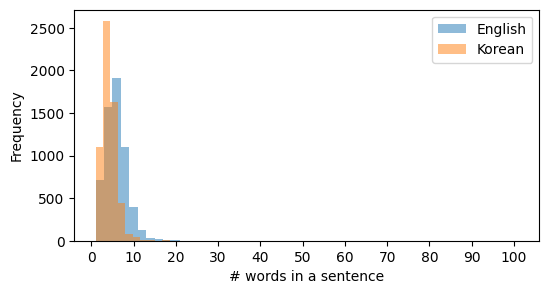

In [6]:
input_lang_word_freq = [len(p[0].split(' ')) for p in pairs]
target_lang_word_freq = [len(p[1].split(' ')) for p in pairs]

fig, ax = plt.subplots(figsize=(6,3))
_ = ax.hist(input_lang_word_freq, label='English', alpha=0.5, bins=50)
_ = ax.hist(target_lang_word_freq, label='Korean', alpha=0.5, bins=50)
_ = ax.set_xticks(np.linspace(0,100,11))
_ = ax.legend()
_ = ax.set_ylabel('Frequency')
_ = ax.set_xlabel('# words in a sentence')

In [7]:
# Since most sentences have less than 10 words, let us use maxium length = 10
MAX_LENGTH=10
pairs = [p for p in pairs if len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH]
print("Number of English and Korean sentence pairs after filtering out long sentences = %d"%(len(pairs)))

Number of English and Korean sentence pairs after filtering out long sentences = 5565


## Step 3: Make English and Korean vocabularies
To run model training, words in sentences need to be converted to integer-based indexes. For each of the input and target languages, we will create a vocabulary that maps its words to an integer. We simply add the word index by 1 when the vocabulary encounters a new word. Notably, there are 3 special indexes: 0 represents padding (PAD) used to fill gaps between sequence length and the maximum length, 1 represents start of string (SOS), and 2 represents end of string (EOS).

In [8]:
# special indexes
PAD_token = 0
SOS_token = 1
EOS_token = 2

# dictionaries mapping word to index
input_lang_word2index = {'PAD':PAD_token, 'SOS':SOS_token, 'EOS':EOS_token}
target_lang_word2index = {'PAD':PAD_token, 'SOS':SOS_token, 'EOS':EOS_token}

# dictionaries mapping index to word
input_lang_index2word = {PAD_token:'PAD', SOS_token:'SOS', EOS_token:'EOS'}
target_lang_index2word = {PAD_token:'PAD', SOS_token:'SOS', EOS_token:'EOS'}

# construct both types of dictionaries
for p in pairs:
    # input language
    for word in p[0].split(' '):
        if word not in input_lang_word2index:
            input_lang_word2index[word] = len(input_lang_word2index)
            input_lang_index2word[input_lang_word2index[word]] = word

    # target language
    for word in p[1].split(' '):
        if word not in target_lang_word2index:
            target_lang_word2index[word] = len(target_lang_word2index)
            target_lang_index2word[target_lang_word2index[word]] = word

print("Number of unique words in English vocabulary = %d"%(len(input_lang_word2index)))
print("Number of unique words in Korean vocabulary = %d"%(len(target_lang_word2index)))

Number of unique words in English vocabulary = 3150
Number of unique words in Korean vocabulary = 7291


## Step 4: Prepare training data for neural network model
The input_data and target_data are both matrices with dimension (number of sentences, maximum sentence length). For sentences with less than MAX_LENGTH words, we fill the gaps by 0 (PAD token). Do not forget to add "end of string" (EOS) token to the end of each sequence.

Typically, we do not pass training data all at once, which can be memory-intensive and computationally expensive.
Instead, we divide all training data into several batches (called mini-batches) and each time one mini-batch is used to compute and update the model parameters.
Here *batch_size* refers to the number of sentences in each mini-batch.
Additionally, we use DataLoader class to faciliate data loading and batching during training or inference.

In [9]:
# construct input_data and target_data matrices
n = len(pairs) # number of paired sentences
input_data = np.zeros((n, MAX_LENGTH), dtype=np.int32) # number of sentences by number of words
target_data = np.zeros((n, MAX_LENGTH), dtype=np.int32) # number of sentences by number of words
for idx, (input_sentence, target_sentence) in enumerate(pairs):
    input_sentence_indexes = [input_lang_word2index[word] for word in input_sentence.split(' ')]
    target_sentence_indexes = [target_lang_word2index[word] for word in target_sentence.split(' ')]
    input_sentence_indexes.append(EOS_token) # add end of sentence token
    target_sentence_indexes.append(EOS_token) # add end of sentence token
    input_data[idx, :len(input_sentence_indexes)] = input_sentence_indexes
    target_data[idx, :len(target_sentence_indexes)] = target_sentence_indexes

# create DataLoader object from the input data matrix
batch_size = 32
train_data = TensorDataset(torch.LongTensor(input_data).to(device), torch.LongTensor(target_data).to(device)) # TensorDataset is a utility class
train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)

## Step 5: Define an encoder-decoder model

A Sequence to Sequence network, or
seq2seq network, or Encoder Decoder
network, is a model consisting
of two Recurrent Neural Networks (RNNs) called the encoder and decoder. The encoder reads an input
sequence and outputs a single vector (context vector), and the decoder reads that vector
to produce an output sequence.

Below we will create a helper class `Lang` to convert between word and word index. This class has two dictionaries that can convert word to index (`word2index`) and word from index (`index2word`).

To read the data file we will split the file into lines, and then split lines into pairs (one English sentence, one Korean translation).

Since there are a *lot* of example sentences and we want to train
something quickly, we\'ll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we\'re filtering to sentences that translate to
the form \"I am\" or \"He is\" etc. (accounting for apostrophes replaced
earlier).


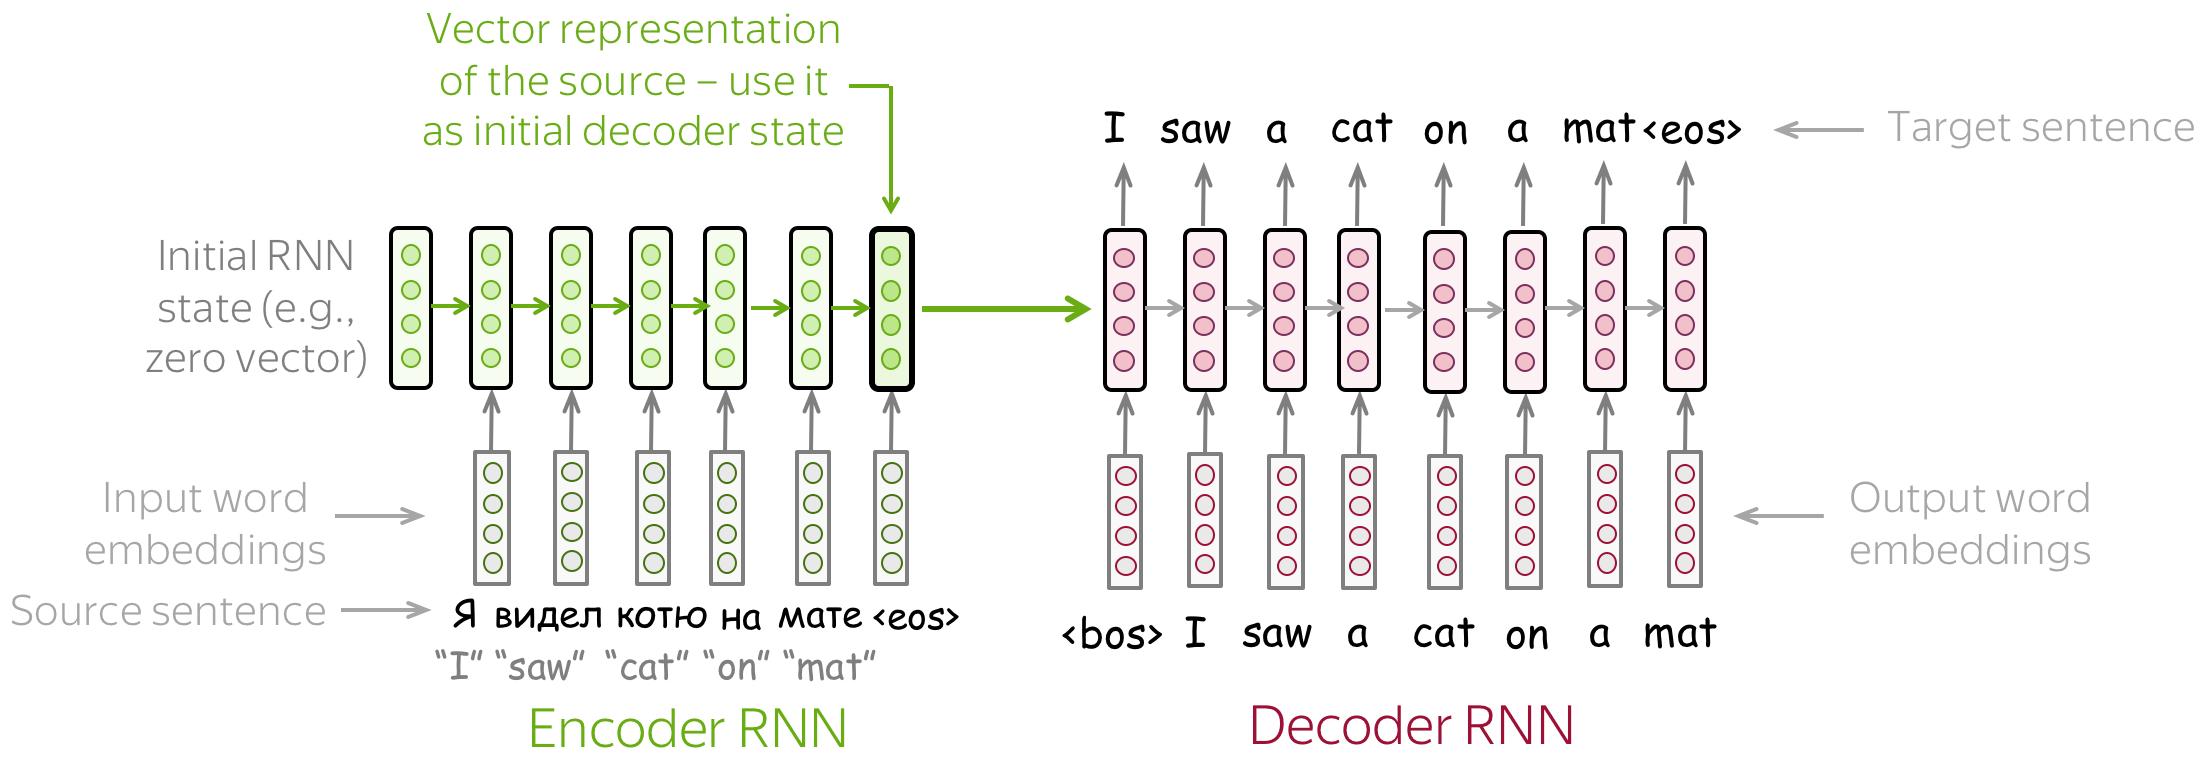

In [10]:
Image(filename='image/encoder_decoder_word_embedding.png', width=800) 

### Why RNN?

A RNN is a type of neural network architecture specifically designed to handle sequential data. RNNs have a hidden state at each time step, which serves as the memory of the network and captures information about previous inputs. The hidden state at time step t is denoted as h(t). This hidden state is updated at every time step to signify the change in the knowledge of the network about the past. Mathematically, h(t) = f(h(t-1), x(t)), where h(t-1) is the hidden state in the previous step and x(t) is the input data at time step t.

RNNs have many nice properties. One of them is that RNNs have recurrent connections that allow them to share the same set of parameters across different time steps of the sequence. These shared parameters are used to compute the hidden state at each time step based on the current input and the previous hidden state. Because the same parameters are reused at each time step, the number of parameters in the model remains constant regardless of the sequence length.

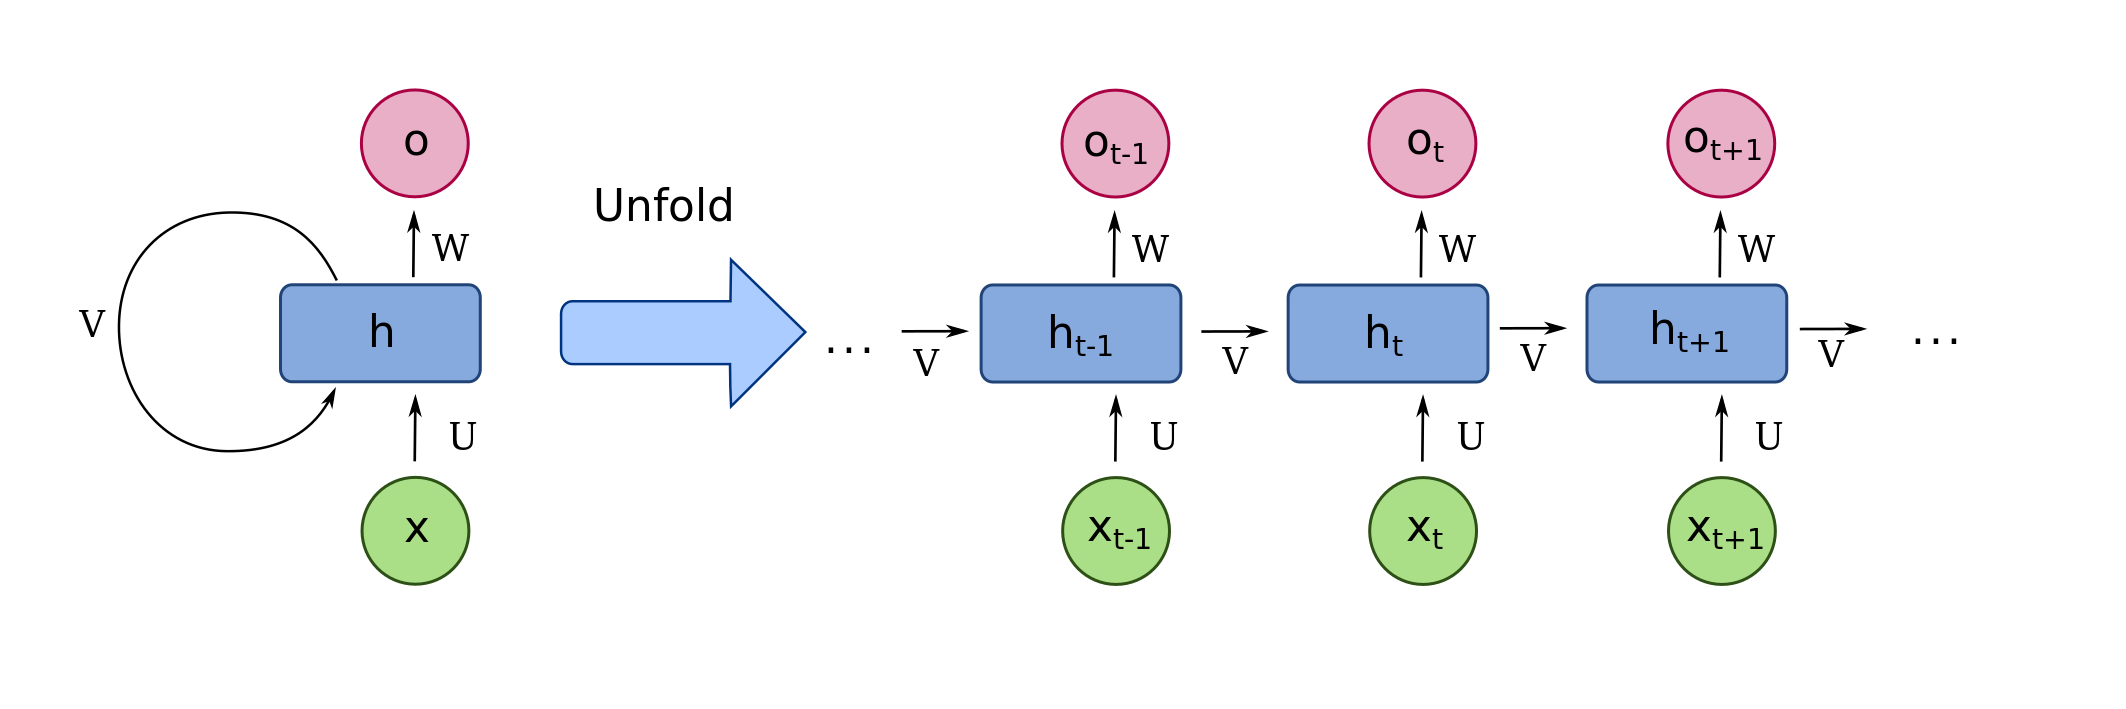

In [11]:
Image(filename='image/Recurrent_neural_network_unfold.png', width=800)

### Gated Recurrent Unit (GRU)

Two popular RNNs are GRU (gated recurrent unit) and LSTM (long short-term memory). In this tutorial, we will use GRU. The structure of a single GRU unit is shown below. During each time step, the GRU cell processes the input vector representing the current word along with the previous hidden state to produce an updated hidden state. The hidden state of the GRU cell serves as a representation of the model's internal state or memory, encoding information about the words processed so far in the sequence.

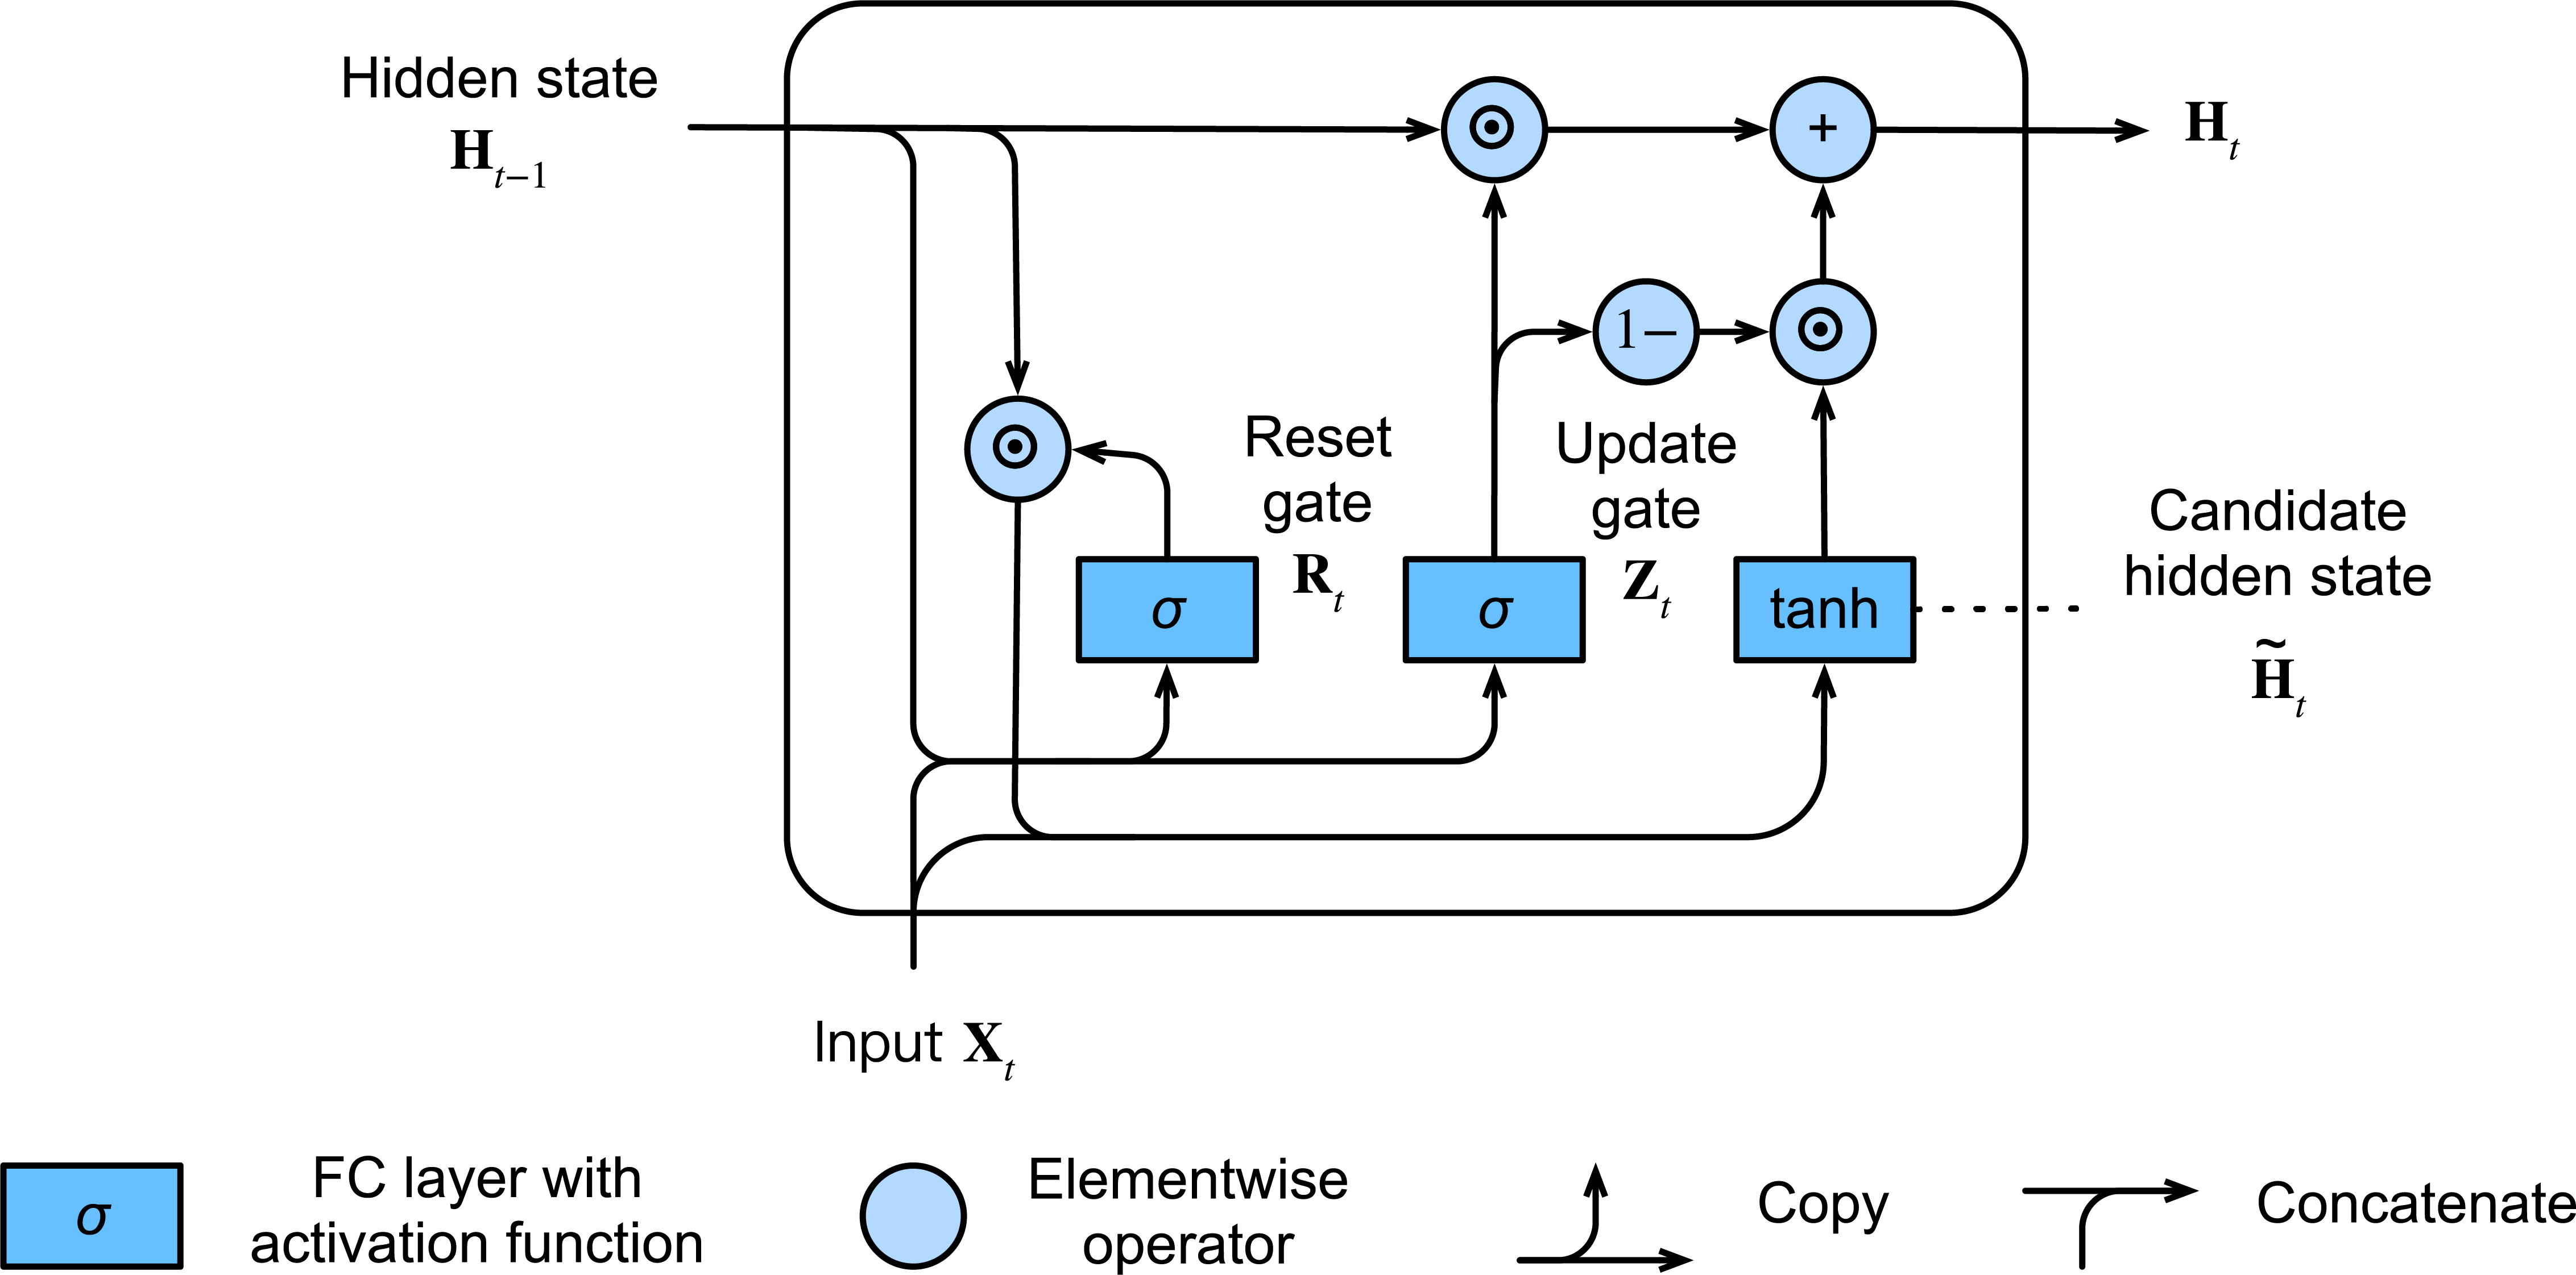

In [12]:
Image(filename='image/schematic_single_gru_cell.png', width=600) 

### Concept of embedding
Now an input sentence is represented by an array of integers. However, integers cannot be directly passed to neural networks because the word indexed by 5 is not necessarily larger than the word indexed by 4. One way to represent these integers is one-hot encoding, where each integer is represented by an array of 0s expcet for 1 at the index equal to the integer. 

However, one-hot encoded vectors form a high-dimensional, sparse space. The nn.Embedding class can map objects from such high-dimensional space to a lower-dimensional, dense vector space where similar objects are represented by nearby vectors. 

To convert integer indexes to dense vector embeddings, the nn.Embedding class initializes a lookup table that has dimension (num_embeddings, embedding_dim). Each row corresponds to the embedding vector for a specific token or index. For example, the embedding vector of the word indexed by 5 is given by the 5th row. In this tutorial, num_embedding represents the unique words in a language, and embedding_dim is the dimensionality at which high-dimensional objects will be compressed to (i.e., the length of embedding vector). Notably, both input and target languages require embedding of their words. 

These embeddings are learned during training and serve as distributed representations of the words. 
Using an embedding layer before feeding input into a RNN is generally preferred over one-hot encoding 
due to its ability to capture semantic information, learnable representations, efficient dimensionality
reduction, and better gradient propagation during training.


### The Encoder

The encoder is a single-layer GRU that outputs a vector and a hidden state for each word (each time step).
The hidden state will be used as input for the next input word.
The input words are passed through an embedding layer before feeding into GRU.​

![](https://pytorch.org/tutorials/_static/img/seq-seq-images/encoder-network.png)

In [13]:
class EncoderRNN(nn.Module):
    def __init__(
        self, 
        input_size,   # vocabulary size of the input language
        hidden_size,  # size of hidden state vector
        dropout_p=0.1 # drop out rate (see explanation below)
    ):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # dimension of embedding matrix: (input_size, hidden_size)
        self.embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=hidden_size)

        # after the embedding layer, each word is represented by a vector of length hidden_size (so the input_size of GRU equals to hidden_size)
        self.gru = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)

        # dropout is a regularization technique commonly used during training neural networks to prevent overfitting and improve generalization performance.
        # it works by randomly setting a fraction of input units (or neurons) to zero during each training iteration,
        # effectively "dropping out" those units from the network. 
        self.dropout = nn.Dropout(dropout_p)

    # the function "forward" specifies how input data is processed through the layers of the model to produce output predictions
    def forward(self, input):
        # dimension of input: (batch_size, sequence_length)
        # dimension of embedded: (batch_size, sequence_length, hidden_size)
        embedded = self.dropout(self.embedding(input))

        # hidden state equals to the last output after reshaping
        # dimension of output: (batch_size, sequence_length, hidden_size)
        # dimension of hidden state: (1, batch_size, hidden_size), where 1 stands for single layer.
        output, hidden = self.gru(embedded)
        return output, hidden

input_size = len(input_lang_word2index) # vocabulary size
hidden_size = 128
encoder = EncoderRNN(input_size, hidden_size).to(device)

### The Decoder

The decoder is another single-layer GRU that outputs a sequence of words to create the translation.
At every step of decoding, the decoder is given a single word and
hidden state from the previous word. The initial input word is the start-of-string `<SOS>`
token, and the first hidden state is the encoder's last hidden state.

Similary, input words are first processed though an embedding layer. Here we use ReLU (=max(0,x)) instead of random dropout. The last dimension of the GRU output vector is hidden_size. However, we hope its last dimension can be output_size (the vocabulary size of the target language) such that each value can represent probability of one word from the target language vocabulary. To achieve the dimensionality change, we pass the output vector through a linear layer (named "out" below) to expand the last dimension to output_size. Finally, softmax (or log-softmax) converts the output vector to probability (or log probability).


![](https://pytorch.org/tutorials/_static/img/seq-seq-images/decoder-network.png)

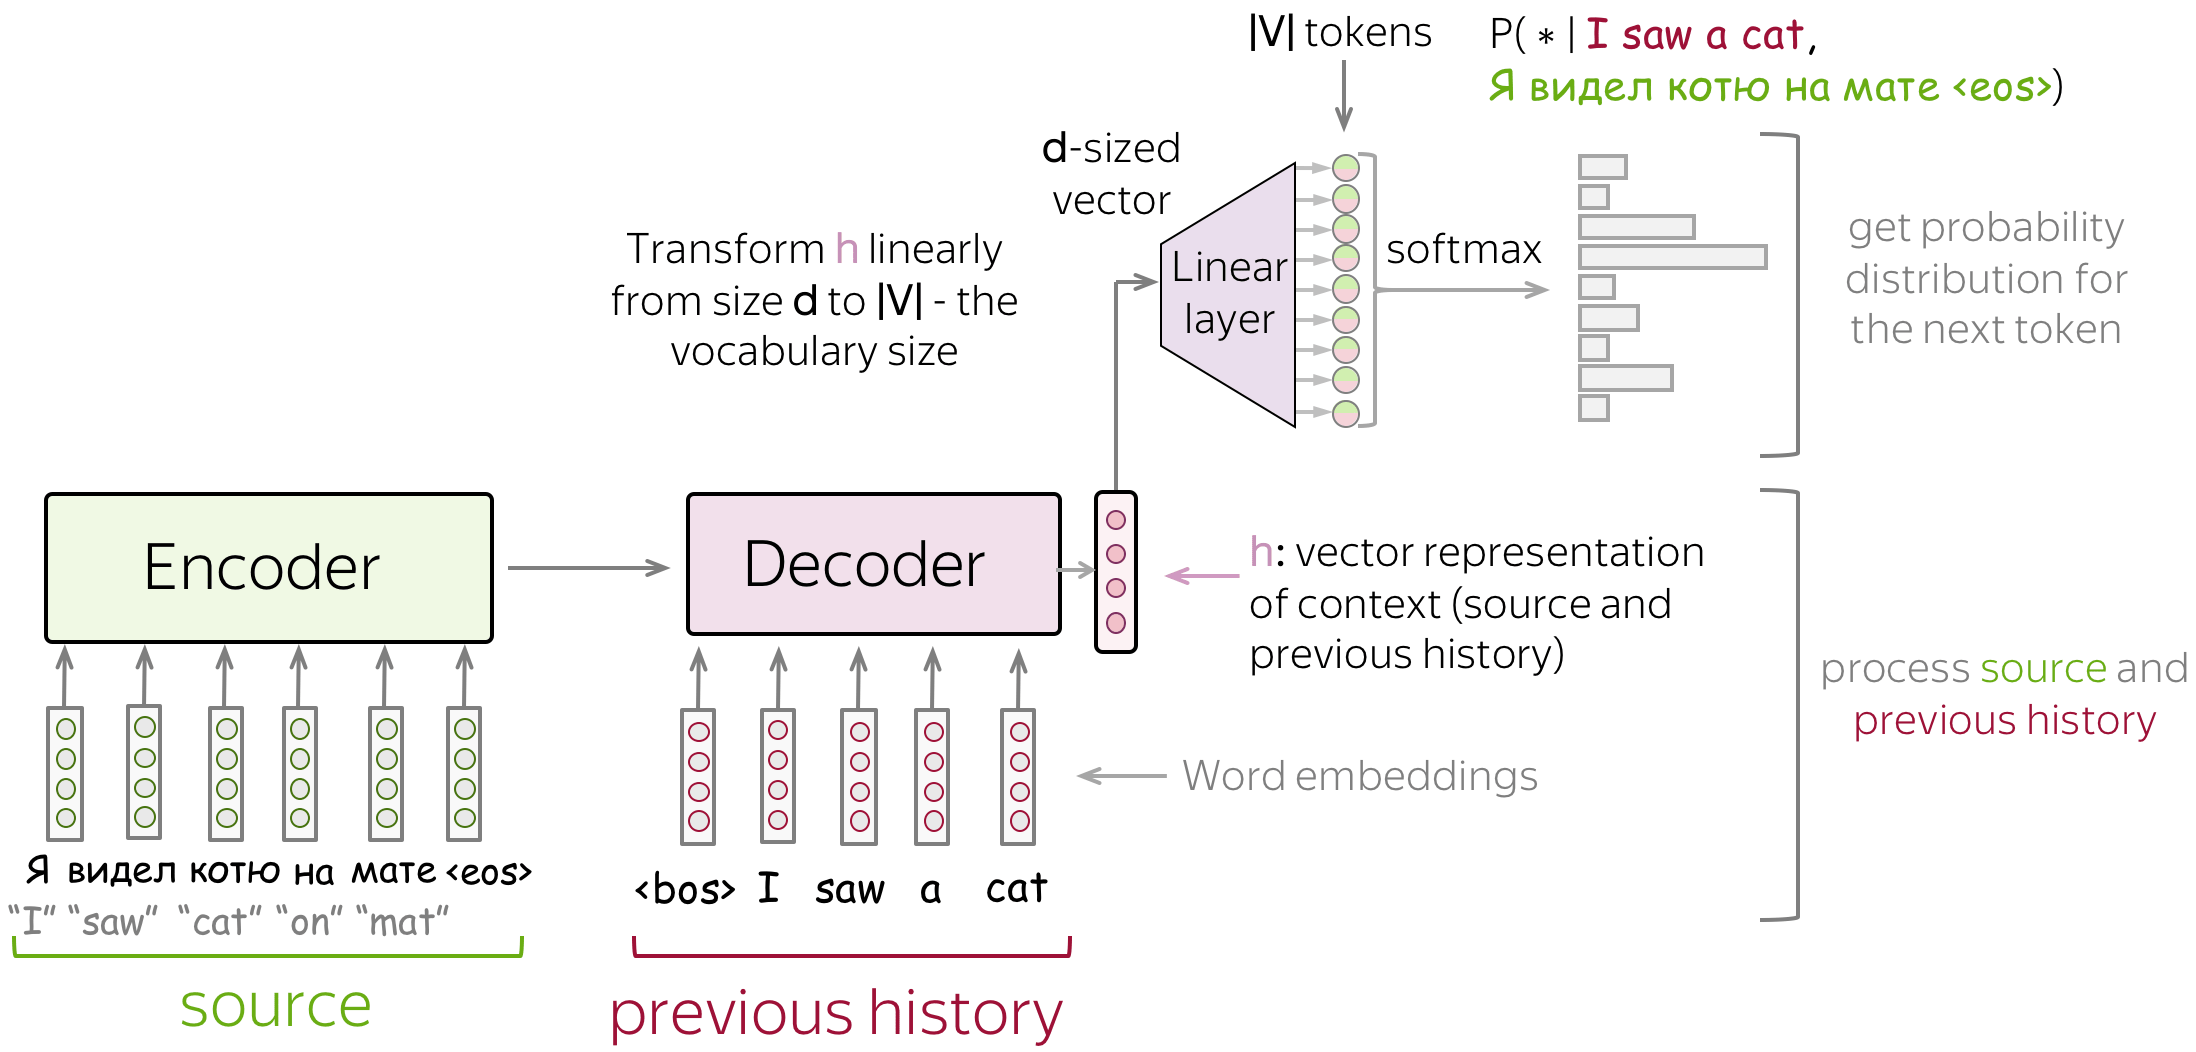

In [14]:
Image(filename='image/encoder_decoder_softmax.png', width=800) 

In [15]:
class DecoderRNN(nn.Module):
    def __init__(
        self,
        hidden_size, # size of hidden state vector
        output_size  # vocabulary size of the target language
    ):
        super(DecoderRNN, self).__init__()
        
        # dimension of embedding matrix: output_size by hidden_size
        self.embedding = nn.Embedding(num_embeddings=output_size, embedding_dim=hidden_size)

        # after the embedding layer, each word is represented by a vector of length hidden_size (so the input_size of GRU equals to hidden_size)
        self.gru = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)

        # transform the last dimension of the output vector from hidden_size to output_size
        self.out = nn.Linear(hidden_size, output_size)

    # run single-word sentence through GRU
    def forward_step(self, input, hidden):
        # dimension of input: (batch_size, 1)
        # dimension of output: (batch_size, 1, hidden size)
        output = F.relu(self.embedding(input))

        # for one-word sentence, output and hidden are the same (after reshape)
        # dimension of output: (batch_size, 1, hidden_size)
        # dimension of hidden: (1, batch_size, hidden_size)
        output, hidden = self.gru(output, hidden)

        # dimension of output: (batch_size, 1, output_size)
        output = self.out(output)
        return output, hidden

    # the function "forward" specifies how input data is processed through the layers of the model to produce output predictions
    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        
        # the first input word of decoder is SOS_toekn, which has dimension (batch_size, 1)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)

        # the first hidden state of decoder is the final hidden state of encoder
        decoder_hidden = encoder_hidden

        # predict word one by one
        decoder_outputs = []
        for i in range(MAX_LENGTH):
            # dimension of decoder_output: (batch_size, 1, output_size)
            # dimension of decoder_hidden: (1, batch_size, hidden_size)
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                # without teacher forcing: use its own predictions as the next input
                # topk returns the k largest elements of the given input tensor along a given dimension (last dimension if not specified) and their indexes (in topi)
                #
                # dimension of topi: (batch_size, 1, 1)
                _, topi = decoder_output.topk(k=1)

                # squeeze: returns a tensor with all specified dimensions of input of size 1 removed.
                # detach returns a new Tensor, detached from the current graph.
                # note: returned Tensor shares the same storage with the original one. In-place modifications on either of them will be seen.
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        # concatenates the given tensors in the given dimension
        # since each tensor in decoder_outputs has a dimension (batch_size, 1, output_size), 
        # dimension of dimension outputs: (batch_size, sequenth_length, output_size)
        decoder_outputs = torch.cat(decoder_outputs, dim=1)

        # turn the last dimension of decoder_outputs (specified by dim=-1) into log probability
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1) # log(softmax(x)), where softmax(x_i) = exp(x_i)/sum_j(exp(x_j))
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

output_size = len(target_lang_word2index)
decoder = DecoderRNN(hidden_size, output_size).to(device)

## Step 6: Model training

To train the neural network model, we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the `<SOS>` token as its first input, and the last hidden state of the
encoder as its first hidden state.

### Concept of epoch:
Neural network training typically occurs over multiple iterations of the entire dataset, known as epochs.
In other words, the neural network must see all training samples once in one epoch (regardless of inputting the training data one-by-one, by mini-batches, or by the entire batch).
In practice, training data is often shuffled before each epoch to introduce stochasticity and prevent the model from overfitting to the order of the data.
Shuffling the data ensures that the model sees the examples in a different order in each epoch, which helps it learn more robust and generalizable patterns.

In [16]:
# we use Adam optimizer to update model parameters
learning_rate = 0.001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

n_epochs = 80
print_every = 5
print_loss_total = 0.0
for epoch in range(1, n_epochs + 1):

    # train model in minibatch (batch_size = 32)
    total_loss = 0
    for data in train_dataloader:
        # dimension of input_tensor and target_tensor: (batch_size, sequence_length)
        input_tensor, target_tensor = data

        # zero_grad() zeroes out the gradients of all parameters in a given model.
        # this operation is typically performed before the backward pass (computing gradients)
        # and updating the model's parameters during the optimization step. 
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        # run encoder and decoder
        #
        # when you define an encoder class in PyTorch and call encoder(input_tensor), 
        # this call invokes the forward method of the encoder class.
        # in PyTorch, the forward method defines the forward pass computation of your model,
        # specifying how input tensors are processed and transformed to produce output tensors.
        # 
        # dimension of encoder_outputs: (batch_size, sequence_length, hidden_size)
        # dimension of encoder_hidden: (1, batch_size, hidden_size)
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        
        # dimension of decoder_outputs: (batch_size, sequence_length, word size)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor) # use teacher forcing
        # decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden) # no teacher forcing

        # compute the loss function
        # NLLLoss: negative log likelihood loss, which is useful to train a classification problem
        # the input given through a forward call is expected to contain log-probabilities of each class.
        # the target that this loss expects should be a class index in the range [0,C-1]
        criterion = nn.NLLLoss()
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)), # view reshape data (the size -1 is inferred from other dimensions)
            target_tensor.view(-1) # view reshape data (the size -1 is inferred from other dimensions)
        )
        
        # backward() computes the gradients of the loss function with respect to the model's parameters
        loss.backward()

        # update model parameters
        encoder_optimizer.step()
        decoder_optimizer.step()

        # add to the loss of the mini-batch to the total loss
        total_loss += loss.item()

    # compute average loss
    ave_loss = total_loss/len(train_dataloader)
    
    # print average loss every 'print_loss_total' steps
    print_loss_total += ave_loss
    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print('epoch %d, average loss = %.4f' % (epoch, print_loss_avg))

epoch 5, average loss = 2.9315
epoch 10, average loss = 1.8941
epoch 15, average loss = 1.1260
epoch 20, average loss = 0.6665
epoch 25, average loss = 0.4227
epoch 30, average loss = 0.2804
epoch 35, average loss = 0.1931
epoch 40, average loss = 0.1379
epoch 45, average loss = 0.1027
epoch 50, average loss = 0.0806
epoch 55, average loss = 0.0663
epoch 60, average loss = 0.0570
epoch 65, average loss = 0.0504
epoch 70, average loss = 0.0459
epoch 75, average loss = 0.0432
epoch 80, average loss = 0.0404


## Step 7: Model evaluation
Evaluation is mostly the same as training, but there are no targets so we simply feed the decoder\'s predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it predicts the EOS token we stop there.

In [18]:
# set dropout layers to eval mode
encoder.eval()
decoder.eval()

test_inputs = [
    "that's very kind", # input in training data
    "i love music",     # input in training data
    "i love movie",     # input NOT in training data
    "i love korea"      # input NOT in training data
]

# the torch.no_grad() block ensures that gradients are not computed during the forward pass through the model, 
# which is useful during inference when gradients are not needed.
with torch.no_grad():
    for test_input in test_inputs:
        # prepare test_input tensor
        test_input_word_indexes = [input_lang_word2index[word] for word in test_input.lower().split(' ')]
        test_input_word_indexes.append(EOS_token)
        test_input_tensor = torch.tensor(test_input_word_indexes, dtype=torch.long, device=device).view(1, -1)
        test_input_tensor = F.pad(test_input_tensor, pad=(0, MAX_LENGTH-test_input_tensor.size(1)), mode='constant', value=PAD_token)

        # compute output of the encoder-decoder network
        encoder_outputs, encoder_hidden = encoder(test_input_tensor)
        decoder_outputs, decoder_hidden, _ = decoder(encoder_outputs, encoder_hidden)

        # predict the output sentence
        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()
        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(target_lang_index2word[idx.item()])
        decoded_sentence = ' '.join(decoded_words)
        
        # print
        print('==========================================')
        print('input English:', test_input)
        print('output Korean:', decoded_sentence)
        print('==========================================')
        print('')

input English: that's very kind
output Korean: 참 친절하구나 <EOS>

input English: i love music
output Korean: 나는 음악을 사랑한다 <EOS>

input English: i love movie
output Korean: 나는 떠난 것을 후회한다 <EOS>

input English: i love korea
output Korean: 나는 하버드에 갔다 <EOS>

